In [1]:
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

import polars as pl

In [2]:
class CustomDataset(Dataset):
    def __init__(self, embeddings, labels):
        # embeddings: list of numpy arrays or torch tensors
        # labels: list of scalars
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)  # or long, depending on your task

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
training_dataset = torch.load("../data/2_ready_for_training/mymethod/training.pt")
testing_dataset = torch.load("../data/2_ready_for_training/mymethod/testing.pt")
val_dataset = torch.load("../data/2_ready_for_training/mymethod/val.pt")

/tmp/ipykernel_10759/3403719866.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_dataset = torch.load("../data/2_ready_for_training/mymethod/training.pt")
/tmp/i

In [4]:
len(val_dataset), len(testing_dataset), len(training_dataset)

(622, 1952, 10403)

In [5]:
class MyMethodNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyMethodNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, 1_024),
            nn.LayerNorm(1_024),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer3 = nn.Linear(1_024, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [6]:
input_dim = 4_096# int(testing_dataset.X[0].shape[0])
hidden_dim = 2_048 # int(testing_dataset.X[0].shape[0]/2)


In [7]:
def main(ix):

    model = MyMethodNeuralNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)
    model = model.to("cuda")

    if ix == 1:
        optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0)
    elif ix == 2:
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
    elif ix == 3:
        optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
    elif ix == 4:
        optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    elif ix == 5:
        optimizer = optim.Adagrad(model.parameters(), lr=1e-4)
    elif ix == 6:
        optimizer = optim.Adamax(model.parameters(), lr=1e-4)

    num_epochs = 25

    # Prepare data loaders
    batch_size = 512

    criterion = nn.MSELoss()
    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)
    train_losses = []
    test_losses = []

    for epoch_num in range(num_epochs):
        test_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to("cuda"), labels.to("cuda")
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(-1), labels)
                # test_loss += loss.item()
                test_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
            avg_loss = test_loss/len(testing_dataset)
            test_losses.append(avg_loss)
            # print(f"TEST LOSS: PRE Epoch-{epoch_num}, we have {avg_loss:.4f}")

        model.train()
        train_loss = 0.0

        # for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch_num}"):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # loss = criterion(outputs, labels) # MY MSITAKE - DO NOT DO THIS
            loss = criterion(outputs.squeeze(-1), labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # train_loss += loss.item()
            train_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
        avg_loss = train_loss/len(training_dataset) # /len(train_dataset) ?? TODO
        train_losses.append(avg_loss)
        # print(f"TRAIN LOSS: On Epoch-{epoch_num}, we have {avg_loss:.4f}")


    return train_losses, test_losses



In [8]:
lst_of_lsts_train = []
lst_of_lsts_test = []

for ix in [1, 2, 3, 4, 5, 6]:
    print(ix)
    a, b = main(ix)
    lst_of_lsts_train.append(a)
    lst_of_lsts_test.append(b)

1
2
3
4
5
6


In [9]:
import numpy as np
import matplotlib.pyplot as plt

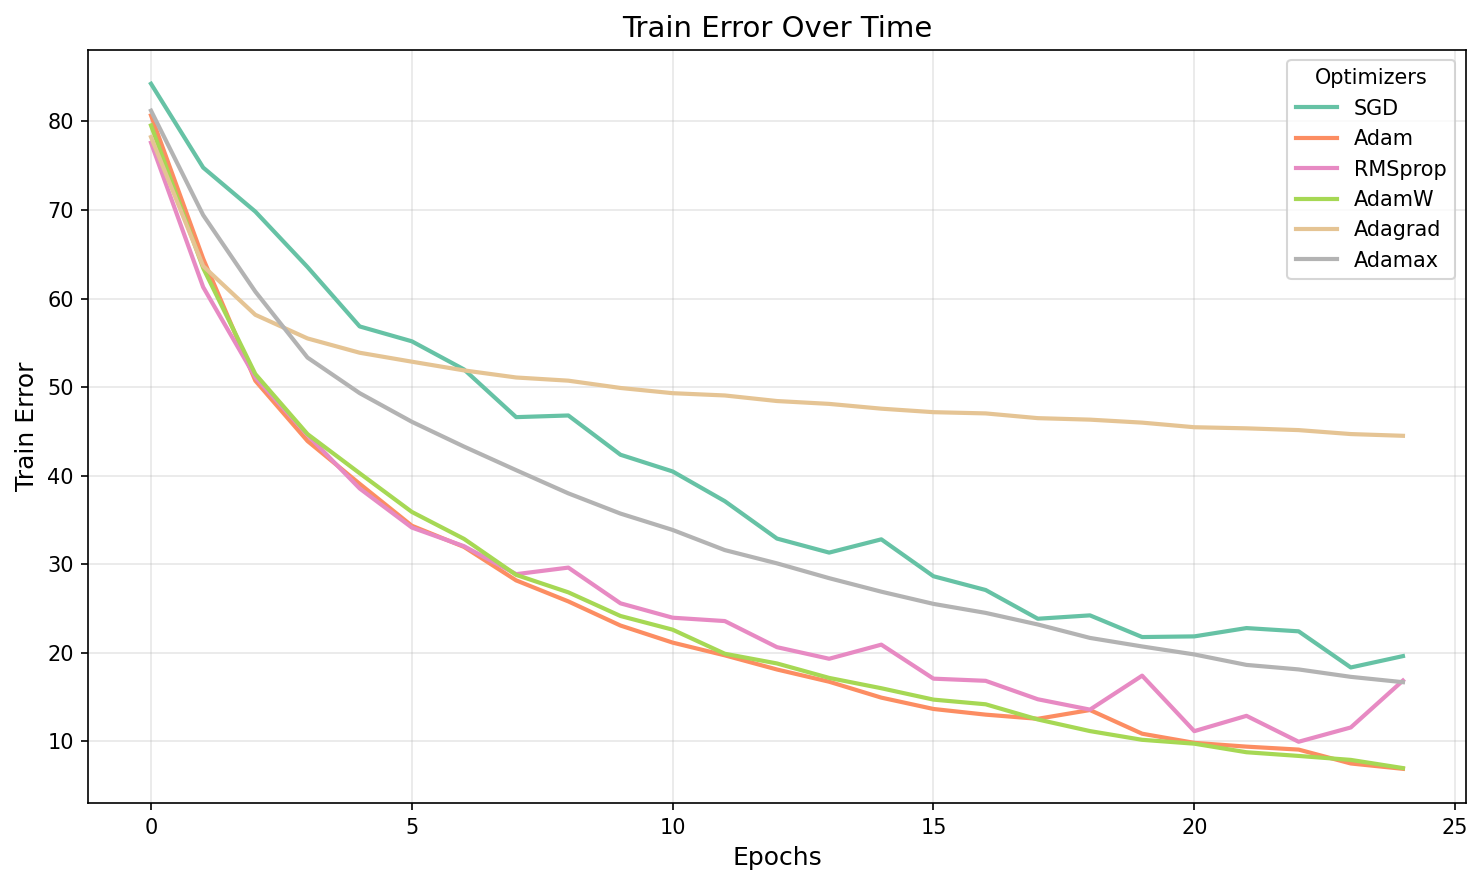

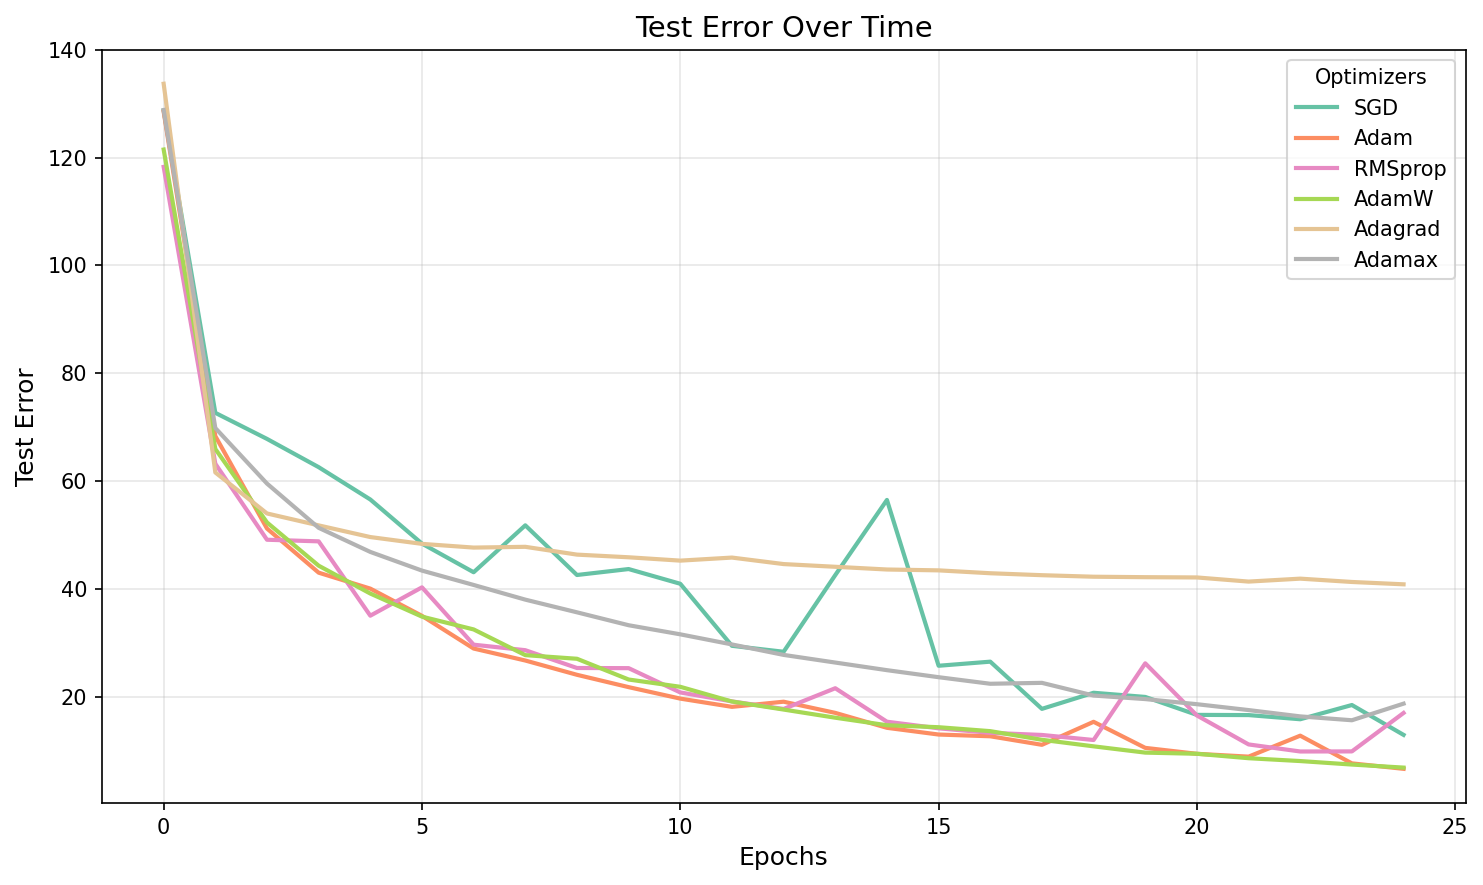

In [10]:
# Labels for the optimizers
labels = ["SGD", "Adam", "RMSprop", "AdamW", "Adagrad", "Adamax"]

# Set white background explicitly
plt.style.use("default")
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white"
})

# Generate a clean color palette
colors = plt.cm.Set2(np.linspace(0, 1, len(labels)))

# Plotting train errors over time
plt.figure(figsize=(10, 6), dpi=150)
for i, (train_errors, label) in enumerate(zip(lst_of_lsts_train, labels)):
    plt.plot(train_errors, label=label, color=colors[i], linewidth=2)

plt.title("Train Error Over Time", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Train Error", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Optimizers", fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/graphics/train_error_over_time_white_bg.png', dpi=300, bbox_inches='tight')
plt.show()

# Plotting test errors over time
plt.figure(figsize=(10, 6), dpi=150)
for i, (test_errors, label) in enumerate(zip(lst_of_lsts_test, labels)):
    plt.plot(test_errors, label=label, color=colors[i], linewidth=2)

plt.title("Test Error Over Time", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Test Error", fontsize=12)
plt.grid(alpha=0.3)
plt.legend(title="Optimizers", fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/graphics/test_error_over_time_white_bg.png', dpi=300, bbox_inches='tight')
plt.show()


In [11]:
!ls ../

data  main.ipynb  models  notebooks  outputs  z_for_running_on_hpc  z.sh
